<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data exploration</a></span></li><li><span><a href="#XGBoost-model" data-toc-modified-id="XGBoost-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-with-Hyperopt" data-toc-modified-id="Hyperparameter-tuning-with-Hyperopt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyperparameter tuning with Hyperopt</a></span></li><li><span><a href="#Model-fitting" data-toc-modified-id="Model-fitting-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model fitting</a></span></li></ul></li><li><span><a href="#Saving-the-model" data-toc-modified-id="Saving-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Saving the model</a></span></li><li><span><a href="#SHAP-values" data-toc-modified-id="SHAP-values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SHAP values</a></span></li><li><span><a href="#Validation-check" data-toc-modified-id="Validation-check-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation check</a></span><ul class="toc-item"><li><span><a href="#Submission-XGB-SCORE" data-toc-modified-id="Submission-XGB-SCORE-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Submission XGB SCORE</a></span></li></ul></li><li><span><a href="#Misc" data-toc-modified-id="Misc-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Misc</a></span></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree
from lightgbm import LGBMClassifier, plot_tree #LGBMRanker
import math
import pickle
import statsmodels.api as sm


import xgboost as xgb

In [3]:
seed=1234

In [4]:
# file_name = "otto_xgb_model_14_ranker_cv.pkl"

In [5]:
df=pd.read_parquet('train_sample_full_cv_3targets_experimental_reduced.parquet')#train_sample_full_cv_hidden_targets_float
# valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental_reduced.parquet')

In [6]:
# df=df[df['MIN_TOP20']<=60]
# valid=valid[valid['MIN_TOP20']<=60]

In [7]:
# df=pd.concat([df,valid])

In [8]:
# df=pd.concat([pd.concat([df[df['TARGET']==1],valid[valid['TARGET']==1]]), pd.concat([df[df['TARGET']==0],valid[valid['TARGET']==0]]).sample(20000000)])

In [9]:
df.columns=[x.lower() for x in df.columns]
# valid.columns=[x.lower() for x in valid.columns]

In [10]:
# del valid

In [11]:
# sessions_with_orders=pd.DataFrame(df.groupby('session_id')['target'].sum()).reset_index()
# sessions_with_orders=sessions_with_orders[sessions_with_orders['target']>0]
# df=df.merge(sessions_with_orders['session_id'], how='inner', on='session_id')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20574641 entries, 0 to 20574640
Data columns (total 51 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   target                          float64
 1   target_clicks                   float64
 2   target_carts                    float64
 3   target_orders                   float64
 4   session_id                      float64
 5   aid                             float64
 6   min_top20                       float64
 7   avg_top20                       float64
 8   max_top20                       float64
 9   in_session                      float64
 10  in_session_clicked              float64
 11  in_session_carted               float64
 12  in_session_ordered              float64
 13  in_session_score                float64
 14  in_session_score_time_weighted  float64
 15  times_in_top20                  float64
 16  times_in_top20_last_week        float64
 17  min_order_hours_from_clic

In [13]:
df.head()

,target,target_clicks,target_carts,target_orders,session_id,aid,min_top20,avg_top20,max_top20,in_session,...,number_orders,first_seen,last_seen,first_bought,last_bought,bought_overall,seen_overall,num_clicks_same_day,num_carts_same_day,num_orders_same_day
0,0.0,0.0,0.0,0.0,8938465.0,564685.0,16.0,16.0,16.0,0.0,...,0.0,491.619506,124.111059,482.864629,124.111059,6.0,39.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,8938465.0,565316.0,50.0,50.0,50.0,0.0,...,0.0,502.813942,74.272007,502.018061,74.285707,36.0,151.0,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,8938465.0,571687.0,98.0,98.0,98.0,0.0,...,0.0,492.177236,27.309626,368.904207,203.731431,6.0,89.0,4.0,0.0,0.0
3,0.0,0.0,0.0,0.0,8938465.0,573913.0,99.0,99.0,99.0,0.0,...,0.0,503.908608,1.141526,495.855277,14.712022,30.0,654.0,7.0,2.0,2.0
4,0.0,0.0,0.0,0.0,8938465.0,602226.0,63.0,63.0,63.0,0.0,...,0.0,490.982738,31.480027,489.757147,175.569146,8.0,106.0,1.0,0.0,0.0


In [14]:
df['null_flag']=(df['avg_order_hours_from_click_avg']<99999).apply(int)
df['in_session_carted_not_ordered']=((df['in_session_carted']>0)&(df['in_session_ordered']==0)).apply(int)
df['in_session_clicked_not_carted']=((df['in_session_clicked']>0)&(df['in_session_carted']==0)).apply(int)

df['in_session_clicked_not_ordered']=((df['in_session_clicked']>0)&(df['in_session_ordered']==0)).apply(int)
df['min_top20_x_in_session_score_time_weighted']=df['min_top20']*df['in_session_score_time_weighted']
df['avg_top20_x_in_session_score_time_weighted']=df['avg_top20']*df['in_session_score_time_weighted']
df['num_clicks_same_day_x_num_carts_same_day']=df['num_clicks_same_day']*df['num_carts_same_day']
df['num_clicks_same_day_x_num_orders_same_day']=df['num_clicks_same_day']*df['num_orders_same_day']
df['num_carts_same_day_x_num_orders_same_day']=df['num_carts_same_day']*df['num_orders_same_day']


# valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
# valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
# valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

In [15]:
df['null_flag'].value_counts(normalize=True)

1    0.751868
0    0.248132
Name: null_flag, dtype: float64

In [16]:
df['target'].value_counts()

0.0    20552278
1.0       22363
Name: target, dtype: int64

In [17]:
#df=df[df['null_flag']==1].reset_index()
#valid=valid[valid['null_flag']==1].reset_index()

In [18]:
df['target'].value_counts()

0.0    20552278
1.0       22363
Name: target, dtype: int64

In [19]:
# rand=np.random.randint(1, 11, df.shape[0])

# train_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand<=8
# valid_mask=(df['sess_days_till_test']+df['sess_duration']/24)>0#rand>8

In [20]:
# df[train_mask]['target'].value_counts()

In [21]:
# df[valid_mask]['target'].value_counts()

In [22]:
col_target='target'
col_exclude=[
'session_id',
'aid',
# 'num_times_ordered_overall',
'number_carts_orders',
'number_carts',
'number_orders',
'sess_days_till_test',
'sess_dayofmonth',
# 'in_session',
# 'in_session_clicked',
# 'in_session_carted',
#  'in_session_ordered',
#  'in_session_score',
# 'first_seen',
# 'first_bought',

'target_clicks',
'target_carts',
'target_orders',
col_target,]

In [23]:
# df[col_target]=df[col_target].apply(int)

# Data exploration

In [24]:
col_preds=[col for col in df.columns[3:] if col not in col_exclude]

In [25]:
len(col_preds)

49

In [26]:
col_preds

['min_top20',
 'avg_top20',
 'max_top20',
 'in_session',
 'in_session_clicked',
 'in_session_carted',
 'in_session_ordered',
 'in_session_score',
 'in_session_score_time_weighted',
 'times_in_top20',
 'times_in_top20_last_week',
 'min_order_hours_from_click_avg',
 'avg_order_hours_from_click_avg',
 'avg_num_sessions_ordered',
 'sum_num_sessions_ordered',
 'avg_num_occured_overall',
 'sum_num_occured_overall',
 'last_num_sessions_ordered',
 'last_hour_num_sessions_ordered',
 'num_times_ordered_overall',
 'sess_num_events',
 'sess_num_clicks',
 'sess_num_carts',
 'sess_num_orders',
 'sess_num_clicks_last_hour',
 'sess_num_carts_last_hour',
 'sess_num_orders_last_hour',
 'sess_duration',
 'sess_minute',
 'sess_hour',
 'sess_dayofweek',
 'first_seen',
 'last_seen',
 'first_bought',
 'last_bought',
 'bought_overall',
 'seen_overall',
 'num_clicks_same_day',
 'num_carts_same_day',
 'num_orders_same_day',
 'null_flag',
 'in_session_carted_not_ordered',
 'in_session_clicked_not_carted',
 'in_s

# XGBoost model

## Hyperparameter tuning with Hyperopt

In [27]:
# from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

# sample_train=df.sample(250000)
# sample_valid=df.sample(100000)

# space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 100,
#         'seed': 0
#     }

# def objective(space):
#     clf=xgb.XGBClassifier(
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']))
    
#     evaluation = [( sample_train[col_preds], sample_train[col_target]), ( sample_valid[col_preds], sample_valid[col_target])]
    
#     clf.fit(sample_train[col_preds], sample_train[col_target],
#             eval_set=evaluation, eval_metric="auc",
#             early_stopping_rounds=10,verbose=False)
    

#     pred = clf.predict_proba(sample_valid[col_preds])[:, 1]
#     gini = mofr.metrics.gini(sample_valid[col_target], pred)
#     print ("SCORE:", gini)
#     return {'loss': -gini, 'status': STATUS_OK }

# trials = Trials()

# best_hyperparams = fmin(fn = objective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 33,
#                         trials = trials)

# del sample_train
# del sample_valid

# hyperparams_name = "best_hyperparams_cv.pkl"

# # save
# pickle.dump(best_hyperparams, open(hyperparams_name, "wb"))

## Model fitting

In [28]:
df=df.sort_values(by='session_id', ascending=True)

In [29]:
# def non_decreasing(L):
#     return all(x<=y for x, y in zip(L, L[1:]))

# non_decreasing(list(X_valid['session_id']))

In [30]:
dtrain = xgb.DMatrix(df[col_preds], df[col_target], qid=list(df['session_id']) ) 

xgb_parms = {'objective':'rank:ndcg', 'tree_method':'gpu_hist'}
xgb_model = xgb.train(xgb_parms, 
    dtrain=dtrain,
    evals=[(dtrain,'train')],
    num_boost_round=2000,
    verbose_eval=100)
xgb_model.save_model(f'XGB_ranker_cv.xgb')

[0]	train-map:0.93540
[100]	train-map:0.94666
[200]	train-map:0.95061
[300]	train-map:0.95400
[400]	train-map:0.95747
[500]	train-map:0.96127
[600]	train-map:0.96495
[700]	train-map:0.96801
[800]	train-map:0.97130
[900]	train-map:0.97418
[1000]	train-map:0.97683
[1100]	train-map:0.97970
[1200]	train-map:0.98211
[1300]	train-map:0.98417
[1400]	train-map:0.98631
[1500]	train-map:0.98797
[1600]	train-map:0.98947
[1700]	train-map:0.99084
[1800]	train-map:0.99197
[1900]	train-map:0.99312
[1999]	train-map:0.99397


In [31]:
# from sklearn.model_selection import GroupKFold

# skf = GroupKFold(n_splits=5)
# for fold,(train_idx, valid_idx) in enumerate(skf.split(df, df[col_target], groups=df['session_id'] )):

#     X_train = df.sort_values(by='session_id', ascending=True).loc[train_idx, col_preds+['session_id']]
#     y_train = df.sort_values(by='session_id', ascending=True).loc[train_idx, col_target]
#     X_valid = df.sort_values(by='session_id', ascending=True).loc[valid_idx, col_preds+['session_id']]
#     y_valid = df.sort_values(by='session_id', ascending=True).loc[valid_idx, col_target]

#     # IF YOU HAVE 50 CANDIDATE WE USE 50 BELOW
#     dtrain = xgb.DMatrix(X_train[col_preds], y_train, qid=list(X_train['session_id']) ) 
#     dvalid = xgb.DMatrix(X_valid[col_preds], y_valid, qid=list(X_valid['session_id']) ) 

#     xgb_parms = {'objective':'rank:pairwise', 'tree_method':'gpu_hist'}
#     model = xgb.train(xgb_parms, 
#         dtrain=dtrain,
#         evals=[(dtrain,'train'),(dvalid,'valid')],
#         num_boost_round=1000,
#         verbose_eval=100)
#     model.save_model(f'XGB_fold{fold}_click.xgb')

In [32]:
df['XGB_SCORE']=xgb_model.predict(dtrain)
# train['XGB_SCORE']=xgb_model.predict_proba(train[col_preds])[:, 1]
# valid['XGB_SCORE']=xgb_model.predict_proba(valid[col_preds])[:, 1]

In [33]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[col_target], df['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[col_target].apply(int), df['XGB_SCORE'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(valid[col_target], valid['XGB_SCORE'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(valid[col_target].apply(int), valid['XGB_SCORE'])))
# # print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
# print('\n')

The Lift on the train set is: 9.961991272543619
The gini on the train set is: 0.9920797815757019




In [34]:
# from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
# df['one']=1

# rce=ROCCurveEvaluator()
# rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
# rce.get_graph()

# del df['one']

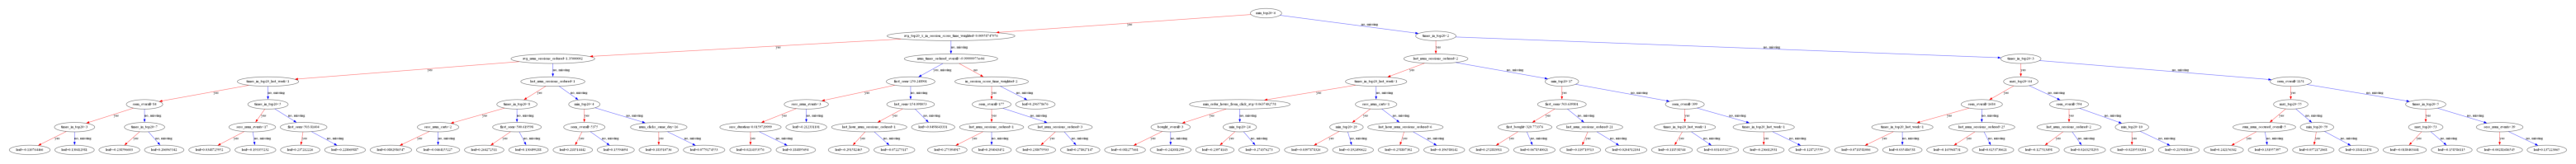

In [35]:
import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files/Graphviz/bin/'

from xgboost import plot_tree
plt.rcParams["figure.figsize"] = (40,40)
plot_tree(xgb_model)
plt.show()

In [36]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

# Validation check

In [37]:
del df
# del train

In [38]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math
import pickle


import xgboost as xgb

In [39]:
# file_name = "otto_xgb_model_13_experimenting_lb_586.pkl"

# #load
# xgb_model= pickle.load(open(file_name, "rb"))

In [40]:
col_target='target'

In [41]:
valid=pd.read_parquet('valid_sample_full_cv_3targets_experimental.parquet')
valid.columns=[x.lower() for x in valid.columns]
valid['null_flag']=(valid['avg_order_hours_from_click_avg']<99999).apply(int)
valid['in_session_carted_not_ordered']=((valid['in_session_carted']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['in_session_clicked_not_carted']=((valid['in_session_clicked']>0)&(valid['in_session_carted']==0)).apply(int)

valid['in_session_clicked_not_ordered']=((valid['in_session_clicked']>0)&(valid['in_session_ordered']==0)).apply(int)
valid['min_top20_x_in_session_score_time_weighted']=valid['min_top20']*valid['in_session_score_time_weighted']
valid['avg_top20_x_in_session_score_time_weighted']=valid['avg_top20']*valid['in_session_score_time_weighted']
valid['num_clicks_same_day_x_num_carts_same_day']=valid['num_clicks_same_day']*valid['num_carts_same_day']
valid['num_clicks_same_day_x_num_orders_same_day']=valid['num_clicks_same_day']*valid['num_orders_same_day']
valid['num_carts_same_day_x_num_orders_same_day']=valid['num_carts_same_day']*valid['num_orders_same_day']

valid['XGB_SCORE']=xgb_model.predict(xgb.DMatrix(valid[xgb_model.feature_names]))

XGBoostError: bad allocation

In [ ]:
# result=[]
# for i in [100,90,80,70,60,50,40,30]:
#     valid_=valid[valid['min_top20']<=i]
#     gini=mofr.metrics.gini(valid_[col_target], valid_['XGB_SCORE'])
#     a=valid_[['session_id', 'aid', 'XGB_SCORE',col_target]].groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
#     num_captured=np.sum(a[col_target])
#     print (i,gini, num_captured)
#     result.append((i,gini, num_captured))
    
# pd.DataFrame(result)

In [ ]:
valid.head()

In [ ]:
valid[col_target].value_counts()

In [ ]:
# coverage=(pd.DataFrame(df.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(df.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the train set is: {target_coverage}')
# print(f'The mean coverage of carts on the train set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the train set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

In [ ]:
# coverage=(pd.DataFrame(valid.groupby('session_id')[col_target].apply(np.sum)).reset_index()).merge(valid.groupby('session_id')[['number_carts_orders','number_carts', 'number_orders']].apply(np.mean), how='inner', on='session_id')
# target_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target'])/np.sum(coverage[coverage['number_carts_orders']>0]['number_carts_orders'].apply(lambda x: min([20,x])))
# # target_avg_coverage=np.sum(coverage[coverage['number_carts_orders']>0]['target']/coverage[coverage['number_carts_orders']>0]['number_carts_orders'])
# target_avg_coverage_carts=np.sum(coverage[coverage['number_carts']>0]['target'])/np.sum(coverage[coverage['number_carts']>0]['number_carts'].apply(lambda x: min([20,x])))
# target_avg_coverage_orders=np.sum(coverage[coverage['number_orders']>0]['target'])/np.sum(coverage[coverage['number_orders']>0]['number_orders'].apply(lambda x: min([20,x])))

# print(f'The coverage of the target on the valid set is: {target_coverage}')
# print(f'The mean coverage of carts on the valid set is: {target_avg_coverage_carts}')
# print(f'The mean coverage of orders on the valid set is: {target_avg_coverage_orders}')
# print(f'Max score possible with this set is: {0.1*0.5+0.3*target_avg_coverage_carts+0.6*target_avg_coverage_orders}')

## Submission XGB SCORE

In [ ]:
a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['XGB_SCORE'], ascending = [False]).head(20).reset_index(drop = True)).reset_index(drop = True)
a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [ ]:
# a=valid.groupby('session_id').apply(lambda x : x.sort_values(by = ['in_session','times_in_top20','XGB_SCORE'], ascending = [False,False,False]).head(20).reset_index(drop = True)).reset_index(drop = True)
# a['session_id']=a['session_id'].apply(lambda x: str(int(x)))
# a['aid']=a['aid'].apply(lambda x: str(int(x)))
    
# pred_df=pd.DataFrame(a.groupby('session_id')['aid'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'aid':'labels'})

In [ ]:
# TOP CLICKS AND ORDERS IN TEST
top_clicks = ['485256', '1460571','108125','1551213','33343','613493','876493','152547','184976','1236775'
              ,'1406660','836852','331708','1531805','29735','554660','634452','986164','959208','832192']

top_carts = ['485256', '33343','613493','152547','876493','1406660','1736857','166037','1460571','1236775'
             ,'554660','660655','1531805','1022566','231487','122983','1562705','923948','332654','544144']

top_orders = ['876493', '1406660','1236775','166037','1460571','1531805','836852','634452','923948','1043508'
             ,'832192','258353','801774','332654','1596897','29735','544144','1581568','1462420','1006198']

In [ ]:
submission_clicks_valid=pred_df.copy()
submission_carts_valid=pred_df.copy()
submission_orders_valid=pred_df.copy()

submission_clicks_valid['session_type']=submission_clicks_valid['session_id'].apply(lambda x: x+'_clicks')
submission_carts_valid['session_type']=submission_carts_valid['session_id'].apply(lambda x: x+'_carts')
submission_orders_valid['session_type']=submission_orders_valid['session_id'].apply(lambda x: x+'_orders')     

In [ ]:
submission_clicks_valid['labels']=submission_clicks_valid['labels'].apply(lambda x: list(x.split(' ')) + top_clicks).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_carts_valid['labels']=submission_carts_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))
submission_orders_valid['labels']=submission_orders_valid['labels'].apply(lambda x: list(x.split(' ')) + top_carts).apply(lambda x: ' '.join(list(dict.fromkeys(x))[0:20]))

In [ ]:
submission_final_valid=pd.concat([submission_clicks_valid[['session_type', 'labels']],submission_carts_valid[['session_type', 'labels']],submission_orders_valid[['session_type', 'labels']]])

In [ ]:
# COMPUTE METRIC
score = 0
weights = {'clicks': 0.10, 'carts': 0.30, 'orders': 0.60}
for t in ['clicks','carts','orders']:
    sub = submission_final_valid.loc[submission_final_valid.session_type.str.contains(t)].copy()
    sub['session'] = sub.session_type.apply(lambda x: int(x.split('_')[0]))
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('test_cv_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==t]
    test_labels = test_labels.merge(sub, how='inner', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    score += weights[t]*recall
    print(f'{t} recall =',recall)
    
print('=============')
print('Overall Recall =',score)
print('=============')

# Misc